<a name="02_prepare"></a>
# 3. Build a Time Series Data Model with Keras
<hr>
In this notebook, we will construct and train a neural network using _Keras_ that can ingest the prepared data and make a prediction at each timestep of the patient's probability of survival.  We'll then compare its accuracy against industry baseline models.

3.1 [**Design the LSTM Network Architecture**](#03_construct)<br>
&nbsp; &nbsp; &nbsp;3.1.1 [Recurrent Neural Network Models](#03_rnn)<br>
&nbsp; &nbsp; &nbsp;3.1.2 [Construct an LSTM Network with *Keras*](#03_lstm)<br>
&nbsp; &nbsp; &nbsp;3.1.3 [Model Architecture Decisions](#03_decisions)<br>
3.2 [**Train the Model**](#03_train)<br>
3.3 [**Evaluate the Model Using Validation Data**](#03_evaluate)<br>
3.4 [**Visualize the Results**](#03_visualize)<br>
3.5 [**Compare the Baseline to PRISM3 and PIM2**](#03_compare)<br>
3.6 [**Conclusion**](#03_conclusion)<br>

First, import the libraries for the new notebook
We also need to reload the data saved at the end of the previous notebook as `.npy` (_NumPy array_) files.

In [1]:
import os
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random
import tensorflow.keras as keras

# configure notebook to display plots
%matplotlib inline

# set up user paths
data_dir = '/dli/task/data/hx_series'
csv_dir = '/dli/task/csv'

In [2]:
# Fetch the DataFrame's loaded in the problem setup
X_train=np.load('X_train_prepared.npy')
y_train=np.load('y_train_prepared.npy')
X_valid=np.load('X_valid_prepared.npy')
y_valid=np.load('y_valid_prepared.npy')

<a name="03_construct"></a>
## 3.1 Design the LSTM Network Architecture
Traditional deep neural networks, such as those that might be used to classify images, include no memory of the past.  In time series problems like our prediction project, we need a special type of neural network that includes past information as part of its input.

<a name="03_rnn"></a>
### 3.1.1 Recurrent Neural Network Models

A **recurrent neural network** ([RNN](https://developer.nvidia.com/discover/recurrent-neural-network)) is a class of artificial neural network that has memory in the form of feedback loops. The **recurrent connections** in the RNN architecture provide visibility of not just the current data sample, but also the network's previous hidden state. A recurrent network with a feedback loop can be visualized as multiple copies of a neural network, with the output of one serving as an input to the next in time. An RNN is particularly useful when a sequence of data is being processed to make a classification decision or regression estimate, though it can also be used on non-sequential data. Recurrent neural networks are typically used to solve tasks related to time series data. 

<figure>
  <img src="rnn.jpg" alt="rnn">
  <figcaption style="text-align: center;">image credit: wildml.com</figcaption>
</figure>

In theory, RNNs can make use of information in arbitrarily long sequences.  In practice, RNNs are limited to looking back only a few steps due to what is called the [**vanishing gradient**](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  In essence, during the training process, as errors are backpropagated through time, inputs from previous time steps get exponentially down-weighted and are eventually driven to zero (i.e. vanish).

There is a variant of the RNN called the [**long short-term memory** (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) network published by [Hochreiter & Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf) in 1997. LSTMs solve the vanishing gradient problem by augmenting the network with recurrent gates called [**forget gates**](http://www.jmlr.org/papers/volume3/gers02a/gers02a.pdf). A defining feature of the LSTM is that it prevents backpropagated errors from vanishing (or exploding) and instead allows errors to flow backwards through unlimited numbers of "virtual layers" unfolded in time. That is, the LSTM can learn "[very deep](https://arxiv.org/abs/1404.7828)" tasks that require memories of events that happened thousands or even millions of discrete time steps ago. Problem-specific LSTM-like topologies can be [evolved](http://link.springer.com/chapter/10.1007/978-3-642-04277-5_76) and can work even when signals contain long delays or have a mix of low and high frequency components.

<a name="03_lstm"></a>
### 3.1.2 Construct an LSTM Network with *Keras*

We will construct our LSTM network with [_Keras_](https://keras.io). _Keras_ is a high-level neural networks API, written in Python, and capable of running on top of various backend frameworks on CPUs and GPUs.  For this lab, we are running _Keras_ on the [_TensorFlow 2_](https://www.tensorflow.org/api_docs/python/tf/keras) framework.

At each time step,the measurements recorded from an encounter will be used as input to the network, and a probability of survival prediction will be generated. Note that this enables a real-time monitor of the patient's probability of survival and insight into the patient's trajectory, because there is a new prediction on the output every time a new observation is added to the input into the system


<img src="drted_rnn.svg" width="800">

Begin by executing the following cell to build the model architecture, and observe the resulting summary.

In [3]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.1, 'return_sequences': True, 'implementation': 2}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 265)]       0         
_________________________________________________________________
input_masked (Masking)       (None, None, 265)         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, None, 128)         201728    
_________________________________________________________________
output (TimeDistributed)     (None, None, 1)           129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


<a name="03_decisions"></a>
### 3.1.3 Model Architecture Decisions

We created a single LSTM.  The input is sized based on the number of variables in an observation (265) for our data.  There are a number of parameters required in the definition of the architecture, requiring design decisions as follows:
 
**Binary cross entropy loss function** (`binary_crossentropy`) is used to calculate the difference between the calculated and actual results during training, because it is the theoretically optimal cost function for a binary classification problem (in this case, mortality). However, occasionally the Mean Squared Error (MSE) cost function is used since it tends to be a bit more stable numerically.
 
**Dropout** (`dropout`) is used to randomly drop a percentage of elements of the input vector (It drops the same elements of the vector for every time step of the sequence). This forces the network to leverage information contained in potentially covariate variables.  For example, a particular sample Heart Rate may be ‘dropped’, but a combination of systolic/diastolic blood pressure and breathing rate may provide a reasonable proxy.
 
**Recurrent dropout** (`recurrent_dropout`) is the fraction of the units to drop for the linear transformation of the recurrent state.  This is used for similar reasons to traditional dropout in CNNs. It forces the network to utilize all of the hidden nodes such that too much information is not contained in a single hidden unit. In practice this tends to lead to more stable networks.
 
**RMSprop** optimizer is selected because it is a good general optimizer for LSTMs.  See [here](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for more details.  
 
**Learning Rate** (`lr=0.005`) value selected to find a reasonable local minimum within a small number of training epochs for time consideration.  Typically one would likely use an even smaller LR and allow the network to take smaller ‘learning steps’, but that choice requires more training rounds to converge (i.e. slower training).
 
As always with neural networks, there was some amount of hyper-parameter tuning.  It is important to keep in mind that this network has not been optimally tuned.  A handful of reasonable default values were chosen to create a state-of-the-art mortality predictor in the least amount of GPU cycles possible (for tutorial purposes).

Read the [docs](https://keras.io/layers/core/) for more information on core layers in _Keras_. 

<a name="03_train"></a>
## 3.2 Train the Model
Now, lets feed some data into the network for training. Our objective is to train the model on past sequential known data so that we can use the model as a predictor on new data.  

We use a batch size of 128 which means that we update parameters every 128 time steps.  For demonstration purposes we will use only 5 training **epochs**, which means that we run through the entire data set 5 times.  Finally, the verbose option just says to produce status / summary information during the training.

In [4]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1)

Train on 5000 samples
Epoch 1/5
5000/5000 [==============================] - 53s 11ms/sample - loss: 0.0866
Epoch 2/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0694
Epoch 3/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0623
Epoch 4/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0580
Epoch 5/5
5000/5000 [==============================] - 49s 10ms/sample - loss: 0.0544


<a name="03_evaluate"></a>
## 3.3 Evaluate the Model Using Validation Data

Our first task in evaluating the model performance is to predict mortality using the hold out dataset (i.e. validation data).

In [5]:
# Generate model results on the holdout validation set
preds = model.predict(X_valid)

Notice that size of the predictions.  The validation set is smaller than the 5000 encounters we used for the training set.

In [6]:
preds.shape

(2690, 500, 1)

<a name="03_visualize"></a>
## 3.4 Visualize the Results
We have 2,690 patient encounters for testing, and at each of the observations the model predicts survivability.  Lets plot some predictions!

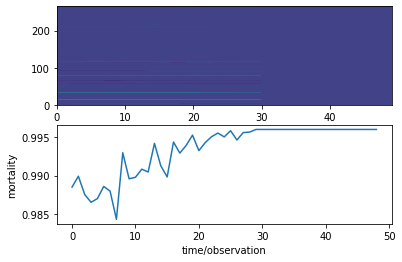

In [7]:
# Figure out how many encounters we have
numencnt = X_valid.shape[0]

# Choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# Create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# Plot the observation chart for the random patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)
plt.ylabel("mortality")
plt.xlabel("time/observation")

# Plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

<a name="03_compare"></a>
## 3.5 Compare Against Baselines: PRISM3 and PIM2

Both PIM2 and PRISM3 are scoring systems for ICU and surgical patients.  Models that predict the risk of death of groups of patients admitted to intensive care are available for adult, pediatric and neonatal intensive care. By adjusting for differences in severity of illness and diagnosis, these models can be used to compare the standard of care between units and within units over time. They can also be used to compare different methods of organising intensive care. Estimating mortality risk is also an important component of comparing groups of patients in research trials.  

The Pediatric Index of Mortality (PIM) was originally developed as a simple model that requires variables collected at the time of admission to intensive care. The original PIM was developed predominantly in Australian units; in the first report only one of the eight units was actually available in the United Kingdom. The PIM2 is a revised mortality index using a more recent data set from 14 intensive care units, eight in Australia, four in the UK, and two in New Zealand. In the analysis for PIM2, 20,787 patient admissions of children less than 16 years of age were included. Since PIM2 estimates mortality risk from data readily available at the time of ICU admission it is therefore suitable for continuous monitoring of the quality of paediatric intensive care. PIM2 uses the first value of each variable measured within the period from the time of first contact to one hour after arrival in the ICU.  If information is missing (e.g. Base Excess is not measured) PIM2 records zero, except for systolic blood pressure, which should be recorded as 120. All consecutive admissions are included.  See [Slater et al.](https://www.ncbi.nlm.nih.gov/pubmed/12541154) for full details.

Similarly, the Pediatric Risk of Mortality ([PRISM](http://www.ncbi.nlm.nih.gov/pubmed/3048900)) score was originally developed around 1988 from the Physiologic Stability Index ([PSI](http://www.ncbi.nlm.nih.gov/pubmed/6728571)) to reduce the number of variables required for pediatric ICU mortality risk assessment, from 34 (in the PSI) to 14 and to obtain an objective weighting of the remaining variables.  Here <a href="http://www.jpeds.com/article/S0022-3476(97)70065-9/abstract">PRISM3</a> is an updated version of the scoring system published in 1996 which has several improvements over the original model. However, it is only available under licence and is not widely used outside of the United States.  The PRISM3 score has 17 physiologic variables subdivided into 26 ranges. The variables determined most predictive of mortality were minimum systolic blood pressure, abnormal pupillary reflexes, and stupor/coma.

First, we compute the **Receiver Operating Characteristic** ([ROC](http://gim.unmc.edu/dxtests/roc2.htm)) information for the predictions from our model so we can compare it to the baseline models.

In [8]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary label for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

Next, we extract precompute PIM2 and PRISM3 estimates from a CSV file.

In [9]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join('/dli/task/csv', 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

Let's now plot these two ROC curves against our RNN model results curve for comparison.

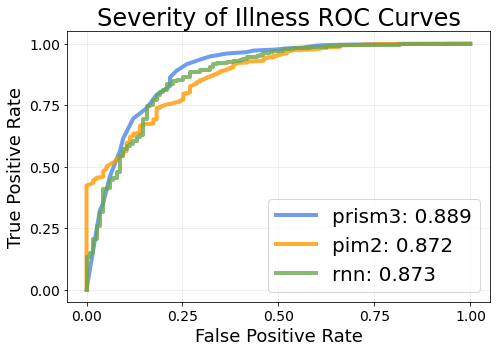

In [10]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

Notice how good this is considering we only did a few rounds of training!


## 3.6 Conclusion
RNNs provide a method to quickly extract clinically significant information and insights from available EHR data.

The amount of data, model complexity, number of features, and number of epochs have been reduced in this tutorial to  reduce computational burden.  The examples below display the performance of a fully trained RNN on a larger dataset.  They also show the performance of PIM2 and PRISM3, two standard scoring systems,  as well as the performance of a logistic regression model and a multi-layer perceptron (MLP).  

The temporally dynamic nature of the RNN enables it to extract more information from the underlying EHR than an MLP.  The MLP's complexity is similar to the RNN's, but the former is limited to instantaneous information.

<img src="RNN_performance.svg" width="500" height="500">

The graph below shows the temporal trajectory of the fully trained RNN's probability of survival predictions. The capability to provide a prediction at any timestep of interest provides valuable feedback to a clinician working to asses the impact of treatment decisions.   

<img src="MortalityThroughTime.svg" width="500" height="500">
